In [18]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import sys

In [20]:
sys.path.append('/content/drive/MyDrive/desihigh/')

In [21]:
from tools import pubplot

In [22]:
import os
import numpy               as     np
import astropy.io.fits     as     fits
import pylab               as     pl
import pandas              as     pd
import matplotlib.pyplot   as     plt 
from   tools        import pubplot

from   IPython.display     import YouTubeVideo
from   scipy               import interpolate
from   scipy               import optimize
from   tools.wave2rgb      import wavelength_to_rgb
from   tools.resample_flux import trapz_rebin
from   pkg_resources       import resource_filename

# A snow white dwarf

When you look to the sky, who knows what you will find?  We're all familiar with our own [sun](https://solarsystem.nasa.gov/solar-system/sun/overview/), 

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/sun.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

a seemingly ever present that we see continually day-to-day.  Would it surprise you to know that in 5.5 billion years the sun will change beyond recognition as the Hydrogen fuelling nuclear fusion within runs out?  

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/RedGiant.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

During this apparent mid-life crisis, the sun will begin to fuse Helium to create the carbon fundamental to life on earth, and the oxygen necessary to sustain it.  Expanding to ten-to-hundreds the size of the sun today, it will soon envelope Mercury & Venus, and perhaps [even Earth itself](https://phys.org/news/2016-05-earth-survive-sun-red-giant.html#:~:text=Red%20Giant%20Phase%3A,collapses%20under%20its%20own%20weight.), and eventual explode as a spectacular [planetary nebulae](https://www.space.com/17715-planetary-nebula.html): 

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/PlanetaryNebulae.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

The ashen carbon-oxygen at the center will survive as a fossilised relic, dissipating energy just slowly enough that it will continue to survive for another 13.8 billion years, the current age of our Universe, and see in many more millenia.

We can learn about this eventual fate of the sun, and its impact on Earth, by studying neighbouring White Dwarves in the Milky Way.  We'll look at one such candidate that DESI has observed only recently!

In [23]:
# Load the DESI spectrum
andes = resource_filename('desihigh', 'student_andes')

zbest = fits.open(andes + '/zbest-mws-66003-20200315-wd.fits')[1]
coadd = fits.open(andes + '/coadd-mws-66003-20200315-wd.fits')

In [27]:
# Get its position on the sky:
ra, dec = float(zbest.data['TARGET_RA']), float(zbest.data['TARGET_DEC'])
z = float(zbest.data['Z'])
print,zbest.header

(<function print>,
 XTENSION= 'BINTABLE'           / binary table extension                         
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                  879 / length of dimension 1                          
 NAXIS2  =                    1 / length of dimension 2                          
 PCOUNT  =                    0 / number of group parameters                     
 GCOUNT  =                    1 / number of groups                               
 TFIELDS =                  162 / number of table fields                         
 TTYPE1  = 'TARGETID'                                                            
 TFORM1  = 'K       '                                                            
 TTYPE2  = 'CHI2    '                                                            
 TFORM2  = 'D       '                                                          

It's position on the night sky lies just above [Ursa Marjor](https://en.wikipedia.org/wiki/Ursa_Major) or the Great Bear,

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/UrsaMajor.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

familiar in the night sky:

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/UrsaMajor2.png?raw=1" alt="Drawing" style="width: 800px;"/>

If you were to stare long enough, you'd see an almost imperceptible change in the apparent position as our viewpoint changes as the Earth orbits the Sun.  Remember, the dinosaurs roamed planet Earth on the other side of the galaxy!

The motion of the Earth around the sun is just enough, given a precise enough instrument, to calculate the distance to our White Dwarf given simple trigonometry you've likely already seen:  

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/PDistance.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

The [GAIA](https://www.esa.int/Science_Exploration/Space_Science/Gaia_overview) space satellite was precisely designed to do this this and will eventually map one billion stars in the Milky Way, roughly one in every hundred there, in this way.

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/Gaia.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

With this parallax, GAIA tells us the distance to our white dwarf:  

In [28]:
# Distance calculated from Gaia parallax (Bailer-Jones et al. 2018).
# Photometric data and the [computed distance](https://ui.adsabs.harvard.edu/abs/2018AJ....156...58B/) can be found at the [Gaia Archive](https://gea.esac.esa.int/archive/)
dist_para = 784.665266     # parcsecs, 1 parsec = 3.0857 x 10^16 m. 

parsec    = 3.085677581e16 # m 

# AU: Astronomical Unit - distance between the Sun and the Earth.
au        = 1.495978707e11 # m

In [29]:
print('GAIA parallax tells us that the distance to our White Dwarf is {:.0f} million x the distance from the Earth to the Sun.'.format(dist_para * parsec / au / 1.e6))

GAIA parallax tells us that the distance to our White Dwarf is 162 million x the distance from the Earth to the Sun.


In [42]:
#What was the parallex?  
para = 1./dist_para
print, para




(<function print>, 0.0012744287829862984)

In [46]:
#Define a function that calculates distance  based on parallax. Parallax must be in arcsec
def distance(r):
    # Vacuum wavelengths of Hydrogen [nanometres], see the Intro.
    result = 1/r
    return result

In [47]:
distance(0.1)

10.0

In [37]:
print('The parallex measured must be {:5.3f} arcsecs.'.format(para * 1.0e0))

The parallex measured must be 0.001 arcsecs.


The GAIA camera is designed to measure the brightness of the white dwarf in three different parts of the visible spectrum, corresponding to the colors shown below.  You'll recognise this as the same style plot we explored for Hydrogen Rydberg lines in the Intro.

In [ ]:
# (Pivot) Wavelengths for the Gaia DR2 filters.
GAIA = {'G_WAVE': 6230.6, 'BP_WAVE': 5051.5, 'RP_WAVE': 7726.2}

(380.0, 780.0)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


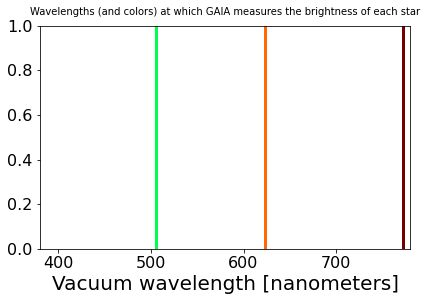

In [ ]:
for wave in GAIA.values():
  # color = [r, g, b]
  color = wavelength_to_rgb(wave / 10.)       
  pl.axvline(x=wave / 10., c=color)

pl.title('Wavelengths (and colors) at which GAIA measures the brightness of each star', pad=10.5, fontsize=10)
pl.xlabel('Vacuum wavelength [nanometers]')
pl.xlim(380., 780.)

In [ ]:
for band in ['G', 'BP', 'RP']:
    GAIA[band + '_MAG']  = zbest.data['GAIA_PHOT_{}_MEAN_MAG'.format(band)][0]    
    GAIA[band + '_FLUX'] = 10.**(-(GAIA[band + '_MAG'] + (25.7934 - 25.6884)) / 2.5) * 3631. / 3.34e4 / GAIA[band + '_WAVE']**2.

In [ ]:
# Add in the mag. errors that DESI catalogues don't propagate.
GAIA['G_MAGERR']  = 0.0044
GAIA['BP_MAGERR'] = 0.0281
GAIA['RP_MAGERR'] = 0.0780

In [ ]:
for key, value in GAIA.items():
    print('{:10s} \t {:05.4f}'.format(key, value))

G_WAVE     	 6230.6000
BP_WAVE    	 5051.5000
RP_WAVE    	 7726.2000
G_MAG      	 19.5145
G_FLUX     	 0.0000
BP_MAG     	 19.3481
BP_FLUX    	 0.0000
RP_MAG     	 19.7099
RP_FLUX    	 0.0000
G_MAGERR   	 0.0044
BP_MAGERR  	 0.0281
RP_MAGERR  	 0.0780


This combination, a measurement of distance (from parallax) and of apparent brightness (in a number of colors), is incredibly powerful, as together they tell us the intrinsic luminosity or brightness of the dwarf rather than how it appears to us, from which we can determine what physics could be determining how bright the white dwarf is.

# DESI

By resolving the subtle variations in the amount of light with wavelength, DESI gives us a much better idea of the White Dwarf composition and its history from its entire spectrum, rather than a few measurements at different colors:

In [ ]:
# Get the wavelength and flux
wave  = coadd[1].data['WAVELENGTH']
count = coadd[1].data['TARGET35191335094848528']

Text(0.5, 1.0, 'TARGET35191335094848528')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


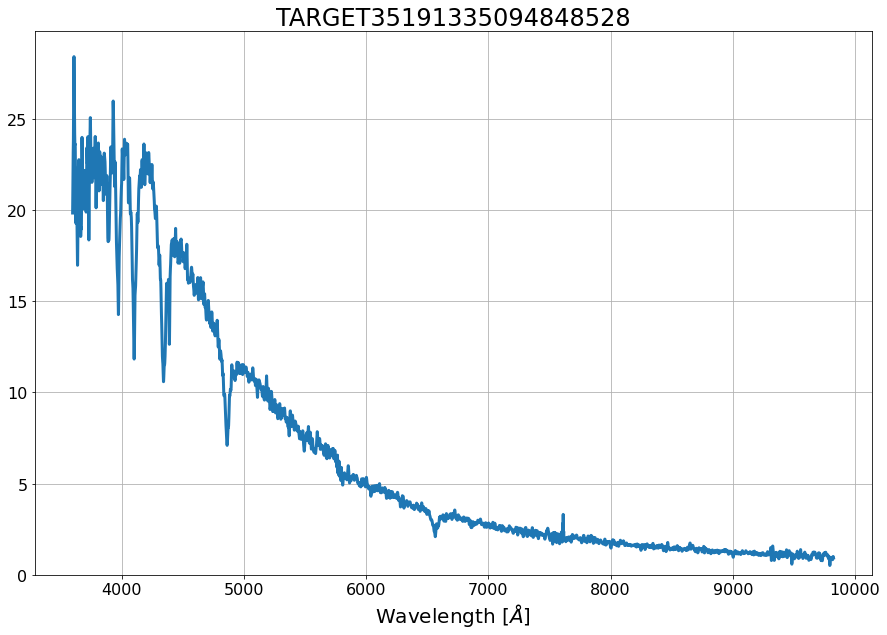

In [ ]:
# Plotting the DESI spectrum
pl.figure(figsize=(15, 10))
pl.plot(wave, count)
pl.grid()
pl.xlabel('Wavelength $[\AA]$')
pl.ylim(ymin=0.)
pl.title('TARGET35191335094848528')

Astronomers have spent a long time studying stars, classifying them according to different types - not least [Annie Jump Cannon](https://www.womenshistory.org/education-resources/biographies/annie-jump-cannon), 

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/anniecannon.jpg?raw=1" alt="Drawing" style="width: 800px;"/>

that has left us with a new ability to predict the spectrum of a star of given temperature, little $g$ - the acceleration due to gravity on their surface, and their mass.  Given 'standard' stars, those with external distance constraints we can also determine how intrinsically bright a given star is with a determined spectrum.  Let's grab these:

In [ ]:
# White Dwarf model spectra [Levenhagen 2017](https://ui.adsabs.harvard.edu/abs/2017ApJS..231....1L)
wdspec             = resource_filename('desihigh', 'dat/WDspec')
spec_da_list       = os.listdir(wdspec)
model_flux_spec_da = []
model_wave_spec_da = []

T_spec_da          = []
logg_spec_da       = []

# Loop over files in the directory and collect into a list. 
for filename in spec_da_list:
    if filename[-4:] != '.npz':
        continue
    model = np.load(wdspec + '/' + filename)['arr_0']
    model_flux_spec_da.append(model[:,1])
    model_wave_spec_da.append(model[:,0])
    T, logg = filename.split('.')[0].split('t0')[-1].split('g')
    T_spec_da.append(float(T) * 1000.)
    logg_spec_da.append(float(logg[:-1]) / 10.)
    
print('Collected {:d} model spectra.'.format(len(spec_da_list)))

Collected 66 model spectra.


Text(0, 0.5, 'Normalised flux')

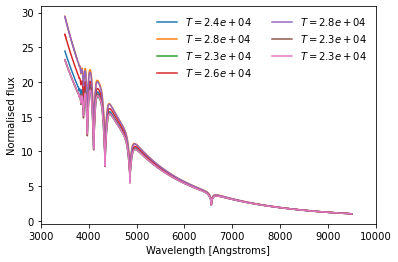

In [ ]:
# We'll select every 10th model white dwarf spectra to plot. 
nth = 10

for model_wave, model_flux, model_temp in zip(model_wave_spec_da[::nth], model_flux_spec_da[::nth], T_spec_da[::nth]):
    pl.plot(model_wave, model_flux / model_flux[-1], label=r'$T = {:.1e}$'.format(model_temp))

# Other commands to set the plot
pl.xlim(3000., 10000.)
# pl.ylim(ymin=1., ymax=3.6)
pl.legend(frameon=False, ncol=2)
pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Normalised flux')

Firstly, these white dwarves are hot!  At 240,000 Kelvin, you shouldn't touch one.  While we can see that the hottest white dwarf is brightest at short wavelength and will therefore appear blue.  In exactly the same way as the bluest part of a flame is the hottest:

<img src="https://github.com/sheejong/desihigh/blob/main/desihigh/images/bunsen.jpg?raw=1" alt="Drawing" style="width: 280px;"/>

So now we have everything to find the temperature of the White Dwarf that DESI was able to find.  As for the Intro., we simply find the model that looks most like the data.  

In [ ]:
# wavelength range to be fitted
wave_min = 3750.
wave_max = 5200.

sq_diff  = []

# Masking the range to be fitted
fitted_range = (wave > wave_min) & (wave < wave_max)
fitted_wave  =  wave[fitted_range] 

for model_wave, model_flux in zip(model_wave_spec_da, model_flux_spec_da):
    # Resample the model resoltuion to match the observed spectrum
    model_flux_resampled = trapz_rebin(model_wave, model_flux, fitted_wave)
    
    # Compute the sum of the squared difference of the individually normalised model and observed spectra
    sq_diff.append(np.sum((model_flux_resampled / np.median(model_flux_resampled) - count[fitted_range] / np.median(count[fitted_range]))**2.))
    
# Unit-weighted least-squared best-fit surface gravity and temperature from the DESI spctrum
arg_min   = np.argmin(sq_diff)
T_desi    = T_spec_da[arg_min]
logg_desi = logg_spec_da[arg_min]

Text(0.5, 1.0, 'DESI White Dwarf:   Temperature = 26000.0 K;  $\\log_{10}$(g) = 7.6')

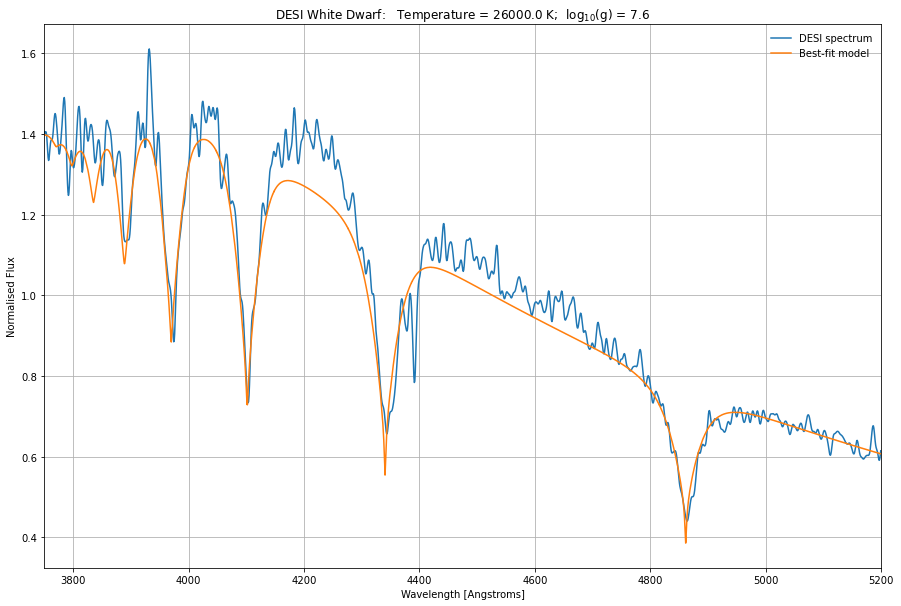

In [ ]:
# Plot the best fit only
fitted_range = (model_wave_spec_da[arg_min] > wave_min) & (model_wave_spec_da[arg_min] < wave_max)
fitted_range_data = (wave > wave_min) & (wave < wave_max)

pl.figure(figsize=(15, 10))
pl.plot(wave[fitted_range_data], count[fitted_range_data] / np.median(count[fitted_range_data]), label='DESI spectrum')
pl.plot(model_wave_spec_da[arg_min][fitted_range], model_flux_spec_da[arg_min][fitted_range] / np.median(model_flux_spec_da[arg_min][fitted_range]), label='Best-fit model')
pl.grid()
pl.xlim(wave_min, wave_max)
pl.xlabel('Wavelength [Angstroms]')
pl.ylabel('Normalised Flux')
pl.legend(frameon=False)
pl.title('DESI White Dwarf:   Temperature = ' + str(T_desi) + ' K;  $\log_{10}$(g) = ' + str(logg_desi))

So our white dwarf is a cool 26,000 Kelvin.  While the surface gravity would be unbearable.  If you remember, the gravitational acceleration is derived from the mass and radius of a body as $g = \frac{G \cdot M}{r^2}$ and is roughly a measure of how dense an object is.  Let's see what this looks like for a few well known sources

In [ ]:
logg = pd.read_csv(resource_filename('desihigh', 'dat/logg.txt'), sep='\s+', comment='#', names=['Body', 'Surface Gravity [g]'])
logg = logg.sort_values('Surface Gravity [g]')
logg

,Body,Surface Gravity [g]
6,Phobos,0.000581
12,Pluto,0.063000
9,Europa,0.134000
4,Moon,0.165000
8,Io,0.183000
1,Mercury,0.377000
5,Mars,0.379000
2,Venus,0.905000
3,Earth,1.000000
10,Saturn,1.065000


Text(0, 0.5, 'Surface gravity [g]')

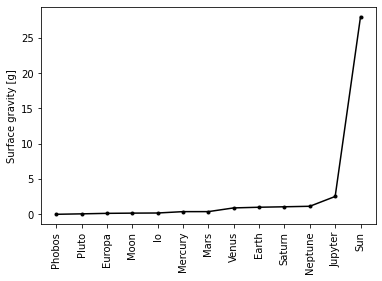

In [ ]:
fig, ax = plt.subplots()

pl.plot(np.arange(0, len(logg), 1), logg['Surface Gravity [g]'], marker='.', c='k')

plt.xticks(np.arange(len(logg)))
ax.set_xticklabels(logg['Body'], rotation='vertical')
ax.set_ylabel('Surface gravity [g]')

So the acceleration on Jupyter is a few times higher than that on earth, while on the Sun it'd be 30 times higher.  The force you feel during takeoff of a flight is roughly 30% larger than the acceleration due to gravity on Earth.  For our DESI white dwarf, the acceleration due to gravity on the surface is:

In [ ]:
logg = 7.6 

g    = 10.**7.6 # cm2 / s.
g   /= 100.     # m2 / s

g   /= 9.81     # Relative to that on Earth, i.e. [g].   
g

40581.770698623535

times higher than that on Earth!  In fact, if it weren't for strange restrictions on what electrons can and cannot not do (as determined by Quantum Mechanics), the White Dwarf would be so dense it would collapse entirely.  Go figure! 

Now it's your turn.  Can you find an class of object even more dense than a White Dwarf?  What is the acceleration due to gravity on its surface?  

Harder(!)  You may be one of the first to see this White Dwarf 'up close'!  What else can you find out about it?  Here's something to get you started ... 

In [ ]:
model_colors = pd.read_csv(resource_filename('desihigh', 'dat/WDphot/Table_DA.txt'), sep='\s+', comment='#') 
model_colors = model_colors[['Teff', 'logg', 'Age', 'G', 'G_BP', 'G_RP']]
model_colors

,Teff,logg,Age,G,G_BP,G_RP
0,2500.0,7.0,5.893000e+09,16.383,16.962,15.680
1,2750.0,7.0,4.242000e+09,16.034,16.736,15.249
2,3000.0,7.0,3.471000e+09,15.733,16.515,14.900
3,3250.0,7.0,3.218000e+09,15.479,16.292,14.627
4,3500.0,7.0,2.981000e+09,15.256,16.058,14.408
...,...,...,...,...,...,...
280,110000.0,9.0,0.000000e+00,10.311,10.034,10.666
281,120000.0,9.0,0.000000e+00,10.233,9.954,10.591
282,130000.0,9.0,0.000000e+00,10.160,9.880,10.521
283,140000.0,9.0,0.000000e+00,10.092,9.811,10.455


The above table shows the model prediction for colors of the white dwarf observed by GAIA, if it had the temperature, age and surface gravity (logg) shown.  

The GAIA colors observed for the DESI white dwarf are:

In [ ]:
GAIA['G_MAG'], GAIA['BP_MAG'], GAIA['RP_MAG']

(19.514544, 19.34811, 19.70989)

In [ ]:
GAIA['G_MAGERR'], GAIA['BP_MAGERR'], GAIA['RP_MAGERR']

(0.0044, 0.0281, 0.078)

Can you figure out how old are White Dwarf is?  What does that say about the age of our Universe?  Does it match the estimates of other [experiments](https://www.space.com/24054-how-old-is-the-universe.html#:~:text=In%202013%2C%20Planck%20measured%20the,universe%20at%2013.82%20billion%20years.)? 

If you get stuck, or need another hint, leave us a [message](https://www.github.com/michaelJwilson/DESI-HighSchool/issues/new)! 